In [1]:
# General Import
import re
import string
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, quantile_transform
%matplotlib inline

In [101]:
# Load Dataset
data = pd.read_csv("dataset.csv")
data = data[pd.notnull(data['Long Text Notif Header'])]

In [102]:
data.shape

(146289, 118)

In [103]:
# Keep only the new columns
file = open("liste des colonnes.txt", "r")
columns = np.intersect1d([line.split('\n')[0] for line in file], data.columns)
data = data[columns]

In [104]:
data.head()

,Activity Code,Activity Code Desc,Activity Long Text,Activity Text,Cause Code,Cause Code Desc,Cause Long Text,Damage,Damage Desc,Equipment,...,Notif Time,Pressure,Required End Date,Required End Time,Required Start Date,Required Start Time,SORT Field,Symptom,Symptom Desc,Temperature
0,IA00,Pas d'activité significative,NaN,,IC60,Général ou inconnue,NaN,ID24,Autre,ZRN1-072181,...,234627.0,1B,20090310.0,0,20090309.0,0.0,EC207D-CE,ZDC00002,Tous équipements,90
1,NaN,NaN,NaN,NaN,IC34,Hors réglage,NaN,ID01,Indication d'instrument anormale,000000000010026533,...,122207.0,ATM,20110513.0,0,20110505.0,122207.0,53AT4031,ZDC00004,Tous équipements,AMBIANTE
2,IA09,Contrôle,NaN,,IC32,Pas de signal/d'indication/d'alarme,NaN,ID24,Autre,000000000010026533,...,20607.0,,20080805.0,0,20080804.0,0.0,53AT4031,ZDC00002,Tous équipements,
3,IA01,Remplacement,NaN,,IC34,Hors réglage,NaN,ID24,Autre,000000000010026533,...,1525.0,,20081022.0,0,20081021.0,0.0,53AT4031,ZDC00002,Tous équipements,
4,NaN,NaN,NaN,NaN,IC24,Usure,NaN,ID11,Défaillance de fonctionnemnt sur sollici,000000000010026533,...,145242.0,,20091016.0,0,20091013.0,145242.0,53AT4031,ZDC00002,Tous équipements,


Activity Long Text        146269
Cause Long Text           145986
Cause Code                104373
Cause Code Desc           104373
Activity Code              62758
Activity Code Desc         62758
Activity Text              62758
Manufacturer               11606
Equipment Catalog          11606
Damage Desc                  369
Damage                       369
Symptom                      369
Symptom Desc                 369
Equipment                      0
Location Desc                  0
Funct Location Desc            0
Funct Location Type            0
Functionnal Location           0
Location                       0
Temperature                    0
Long Text Notif Header         0
Malfunct End date              0
Malfunct End time              0
Malfunct Start date            0
Malfunct Start time            0
Notif Date                     0
Notif Desc                     0
Notif Number                   0
Notif Time                     0
Pressure                       0
Required E

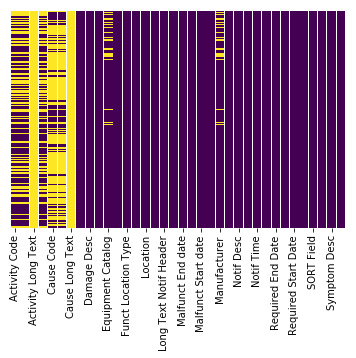

In [105]:
# Let's see if we have missing values
print(data.isnull().sum().sort_values(ascending=False))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Focus on Equipment Catalog

In [106]:
data['Equipment Catalog'].unique()

array(['E', 'I', nan, 'A'], dtype=object)

In [107]:
data['Equipment Catalog'].value_counts()

I    108998
E     25527
A       158
Name: Equipment Catalog, dtype: int64

In [108]:
data['Funct Location Type'].unique()

array(['E', 'I', 'A', '3', 'V', 'P', '4', '2', '1', 'R'], dtype=object)

In [109]:
def fill_emptyness(filed2fill, value):
    if type(filed2fill) != str:
        if np.isnan(filed2fill) and value in ['E', 'I', 'A']:
            return value
    return filed2fill

In [110]:
data['Equipment Catalog'] = data.apply(lambda row: fill_emptyness(row['Equipment Catalog'], row['Funct Location Type']),axis=1)

In [111]:
data['Equipment Catalog'].value_counts()

I    115399
E     30577
A       288
Name: Equipment Catalog, dtype: int64

### Filling Rate

In [118]:
def filling_rate(df):
    """Compute the rate of columns filling"""
    filling_rate_df = pd.DataFrame(columns=['Column Name', 'Filling Rate'])
    # go column by column
    for column in df.columns:
        # NB: df[column].describe() take into account the null values !!
        # we define our own rule in order to take into account the spaced string, empty cell as well as null values
        rate =  1 - ((df[column].isna() | df[column].apply(lambda row: str(row).isspace()) | df[column].eq('')).sum() / df.shape[0])
        filling_rate_df = filling_rate_df.append({'Column Name': column,
                                                  'Filling Rate': rate * 100
                                                 }, ignore_index=True)
    filling_rate_df.plot(x="Column Name", y="Filling Rate", kind='bar', title='filling rate', figsize=(20,10))
    plt.savefig('Taux de remplissage.png')
    return filling_rate_df.sort_values('Filling Rate')

,Column Name,Filling Rate
2,Activity Long Text,0.013672
6,Cause Long Text,0.207124
35,Temperature,5.043441
27,Pressure,5.085823
0,Activity Code,10.233169
4,Cause Code,16.174148
22,Manufacturer,27.505144
5,Cause Code Desc,28.652872
3,Activity Text,54.202982
1,Activity Code Desc,57.099987


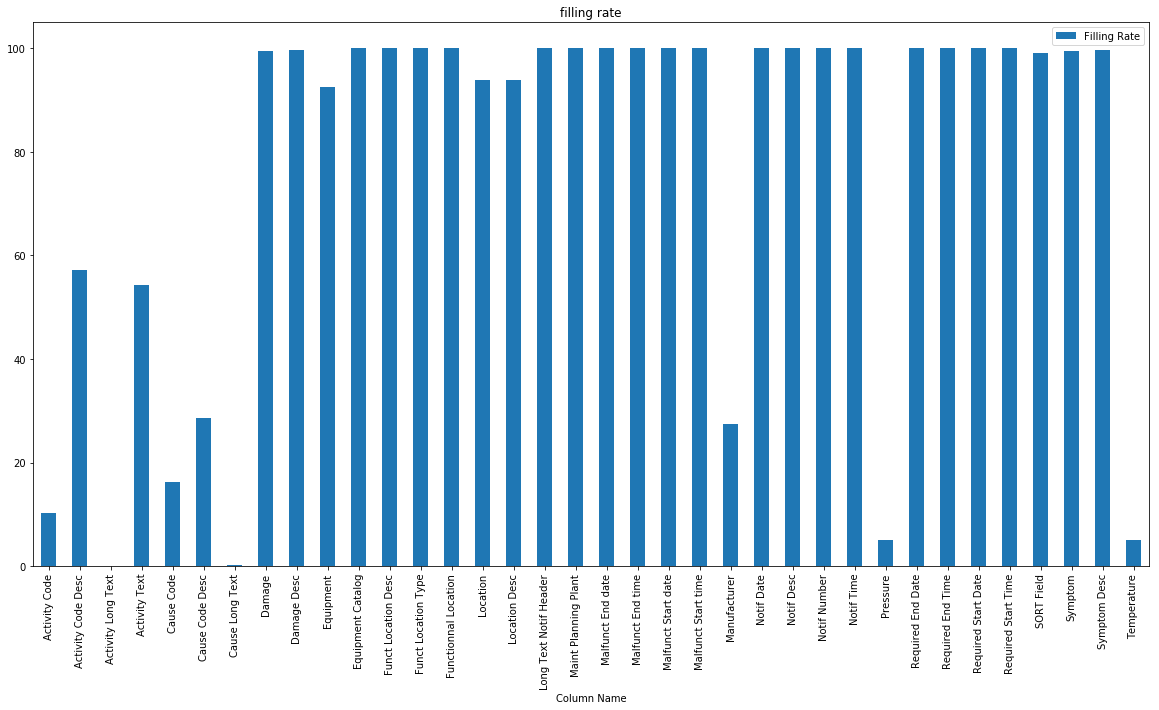

In [119]:
filling_rate(data)

### Stats on Results

In [51]:
data = pd.read_csv('classification resulats.csv')
data = data.drop(['Unnamed: 0'], axis=1)

C:\Users\Geeks Data\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,38,70,90,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
data.head()

,Notif Number,Notif Desc,Functionnal Location,Equipment,Assembly,Required Start Date,Required Start Time,Required End Date,Required End Time,Priority,...,WBS,StandgOrder,Settlement Order,planning group,Catalog Profile,Panne,Lambda,Dang/pas Dang prediction,Detect/pas Detect prediction,Typologie Panne prediction
0,G11202115,"TRANSFO. 5,5/380V 1250KVA",GO-NRJ-TR21P112,GO-XTR39,,20160824.0,0.0,20160824.0,0.0,4,...,0.0,,,EM,ZPM02321,cellule bloquée,NaN,NonDangereux,NonDétectable,panne
1,G10934648,ne démarre pas,GO-NRJ-MP2708,GO-XO3022,,20140425.0,0.0,20140428.0,0.0,1,...,0.0,,,EM,ZPM01841,cellule bloquée,NaN,NonDangereux,NonDétectable,bloquée
2,000013717526,4R1A ne démarre pas,GO-VAP-4RM1A,GO-XO37,,20180719.0,1.0,20180720.0,235900.0,1,...,0.0,,,VM,ZPM01841,cellule bloquée,NaN,NonDangereux,NonDétectable,bloquée
3,G10167004,Moteur précompresseur ne démarre pas,GO-PED-12KBX201,GO-XO70,,20070329.0,0.0,20070330.0,0.0,2,...,0.0,,,DM,ZPM01841,cellule bloquée,NaN,NonDangereux,NonDétectable,bloquée
4,11733639,Pompe ne démarre pas fosse pleine,RN-E72-D2-G3 -G3_DEC2-M,ZRN1-055202,,20090709.0,135433.0,20090830.0,0.0,2,...,0.0,,,A03,ZPM01841,cellule bloquée,NaN,NonDangereux,NonDétectable,panne


In [53]:
data.shape

(146596, 122)

In [54]:
def groupBy(df, columns):
    grpb_df = df.groupby(columns).agg(['count'])[df.columns[0]]
    grpb_df.columns = ['']
    return grpb_df

In [55]:
grpb_panne = groupBy(data, ['Maint Planning Plant', 'Panne'])

In [56]:
grpb_panne

Maint Planning Plant Panne                      
ZRN1                 air                     312
                     alarme                  107
                     bad                       8
                     bad hook-up               2
                     bloqué                    3
                     bloquée                 173
                     bouchage                  2
                     calorifuge               10
                     cellule bloquée           5
                     connexion               228
                     design                    6
                     discordance             122
                     doute                   555
                     déconnexion élec          1
                     erreur                   94
                     fausse                   17
                     fuite process ext       129
                     fuite process int         3
                     grillée                  65
                     instable                 25
                     mécanique                85
                     panne                    76
                     perturbation             38
                     position                102
                     protection             1086
                     repère                   82
                     traçage                  55
                     tuyauterie               58
                     vitesse                   8
                     zero                     10
...                                          ...
ZRN3                 alarme                  365
                     bad                       8
                     bad hook-up               2
                     bloqué                   10
                     bloquée                 697
                     bouchage                  5
                     calorifuge                1
                     cellule bloquée           8
                     connexion               153
                     design                   50
                     discordance              59
                     doute                   552
                     déconnexion élec          2
                     défaut isolement élec     1
                     erreur                   38
                     fausse                   57
                     fuite process ext       262
                     fuite process int         8
                     grillée                  18
                     instable                 81
                     mécanique               246
                     panne                    56
                     perturbation             42
                     position                216
                     protection             1427
                     repère                   49
                     traçage                 207
                     tuyauterie               55
                     vitesse                  20
                     zero                     16

[61 rows x 1 columns]

In [58]:
panne_system_expert = groupBy(data, ['Maint Planning Plant', 'Typologie Panne prediction'])

In [59]:
panne_system_expert

Maint Planning Plant Typologie Panne prediction       
ZRN1                 air                           646
                     alarme                         65
                     autre                          93
                     bad                            12
                     bloquée                       554
                     bouchage                       18
                     calorifuge                      3
                     design                         76
                     discordance                   975
                     doute                          78
                     erreur                         16
                     fausse                        106
                     figée                          10
                     fuite process ext             186
                     fuite process int              30
                     instable                        1
                     panne                       24571
                     perturbation                   10
                     position                      515
                     repère                        488
                     traçage                        43
                     tuyauterie                    392
                     vitesse                         4
                     zero                            2
ZRN3                 air                         15312
                     alarme                         96
                     autre                         420
                     bad                            98
                     bloquée                     10137
                     bouchage                      131
                     design                        337
                     discordance                   669
                     doute                         407
                     défaut isolement élec           1
                     erreur                         73
                     fausse                       4530
                     figée                           5
                     fuite process ext            1749
                     fuite process int             284
                     panne                       81103
                     perturbation                  206
                     position                      741
                     repère                        656
                     traçage                        64
                     tuyauterie                    467
                     vitesse                         6
                     zero                          210

In [60]:
grpb_lambda = groupBy(data, ['Maint Planning Plant', 'Lambda'])

In [61]:
grpb_lambda

Maint Planning Plant Lambda      
ZRN1                 DD         8
                     DU      1038
                     S          2
                     SD       356
                     SU        86
ZRN3                 DD        20
                     DU      1709
                     S          2
                     SD       705
                     SU        72

In [62]:
data['Dang/pas Dang System Expert'] = data['Lambda'].replace(to_replace='D.', value='Dangereux', regex=True)
data['Dang/pas Dang System Expert'] = data['Dang/pas Dang System Expert'].replace(to_replace='S.*', value='NonDangereux', regex=True)

In [63]:
data['Dang/pas Dang System Expert'].unique()

array([nan, 'Dangereux', 'NonDangereux'], dtype=object)

In [64]:
dang_system_expert = groupBy(data, ['Maint Planning Plant', 'Dang/pas Dang System Expert'])

In [65]:
dang_system_expert

Maint Planning Plant Dang/pas Dang System Expert      
ZRN1                 Dangereux                    1046
                     NonDangereux                  444
ZRN3                 Dangereux                    1729
                     NonDangereux                  779

In [66]:
grpb_dang = groupBy(data, ['Maint Planning Plant', 'Dang/pas Dang prediction'])

In [67]:
grpb_dang

Maint Planning Plant Dang/pas Dang prediction        
ZRN1                 Dangereux                   1387
                     NonDangereux               27507
ZRN3                 Dangereux                   3402
                     NonDangereux              114300

In [68]:
data['Detect/pas Detect System Expert'] = data['Lambda'].replace(to_replace = 'DU|SU', value = 'NonDétectable', regex = True)
data['Detect/pas Detect System Expert'] = data['Detect/pas Detect System Expert'].replace(to_replace = 'SD|DD', value = 'Détectable', regex = True)

In [69]:
data['Detect/pas Detect System Expert'].unique()

array([nan, 'NonDétectable', 'Détectable', 'S'], dtype=object)

In [70]:
data['Detect/pas Detect System Expert'] = data['Detect/pas Detect System Expert'].replace('S', np.nan)

In [71]:
detect_system_expert = groupBy(data, ['Maint Planning Plant', 'Detect/pas Detect System Expert'])

In [72]:
detect_system_expert

Maint Planning Plant Detect/pas Detect System Expert      
ZRN1                 Détectable                        364
                     NonDétectable                    1124
ZRN3                 Détectable                        725
                     NonDétectable                    1781

In [73]:
grpb_detect = groupBy(data, ['Maint Planning Plant', 'Detect/pas Detect prediction'])

In [74]:
grpb_detect

Maint Planning Plant Detect/pas Detect prediction        
ZRN1                 Détectable                      1226
                     NonDétectable                  27668
ZRN3                 Détectable                       949
                     NonDétectable                 116753